In [1]:
%matplotlib widget

import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import importlib
import torch

from avalanche.benchmarks.generators import nc_benchmark
from sklearn.model_selection import train_test_split
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    loss_metrics,
    forgetting_metrics,
    confusion_matrix_metrics,
)
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

import clp.clp
from clp.clp import CLP


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [47]:
from torch.utils.data import Dataset, DataLoader

class NpDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.targets = y
    def __len__(self): 
        return len(self.targets)
    def __getitem__(self, i): 
        return self.X[i], self.targets[i]

In [286]:
n_samples = 6400
n_clusters = 7
random_state = np.random.randint(1000)

X_varied, y_varied = make_blobs(
    n_samples=n_samples, centers=n_clusters, cluster_std=np.linspace(0.3,2,n_clusters), random_state=random_state
)  # Unequal variance

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))  # Unevenly sized blobs

y_filtered = [0] * 500 + [1] * 100 + [2] * 10

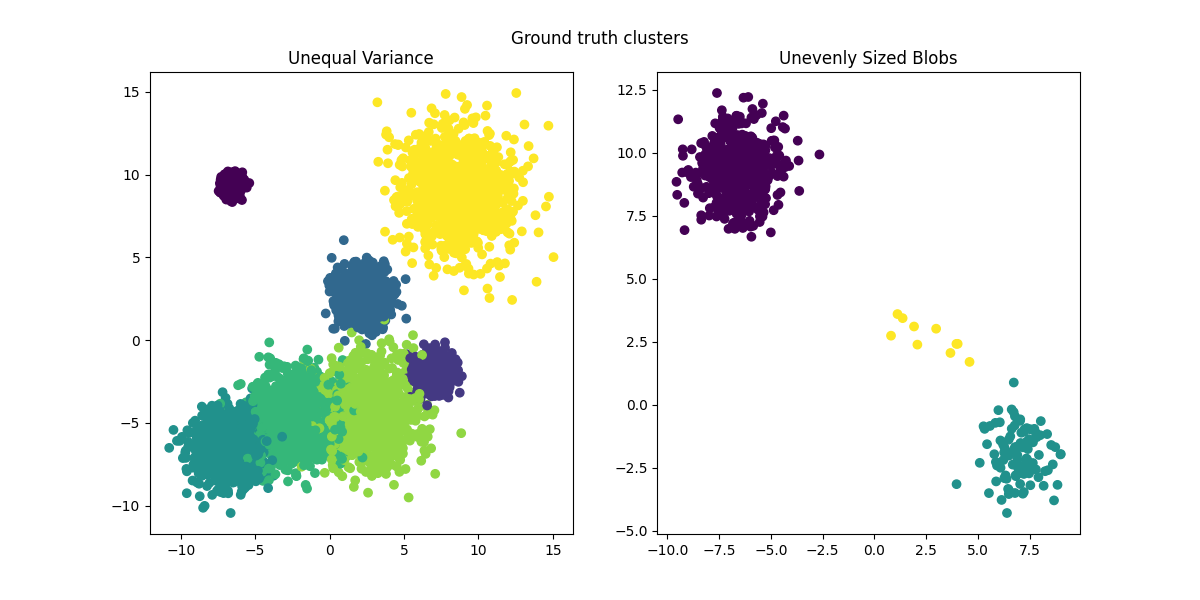

In [287]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axs[0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
axs[0].set_title("Unequal Variance")

axs[1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered)
axs[1].set_title("Unevenly Sized Blobs")

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.show()

In [288]:
X_varied.astype(float)
y_varied.astype(float)

full_ds = NpDataset(X_varied, y_varied)
test_size = 0.4

train_indices, test_indices, _, _ = train_test_split(
            range(len(full_ds)),
            full_ds.targets,
            stratify=full_ds.targets,
            test_size=test_size,
            shuffle=True)

train_ds = NpDataset(X_varied[train_indices], y_varied[train_indices])
test_ds = NpDataset(X_varied[test_indices], y_varied[test_indices])

In [289]:
n_classes = len(np.unique(train_ds.targets))


nc_bm = nc_benchmark(train_ds, test_ds, 
                     n_experiences=n_classes, 
                     shuffle=True,task_labels=False)

In [ ]:
importlib.reload(clp.clp)
from clp.clp import CLP

n_classes = n_clusters
alpha_start = 1
sim_th = -15
k_hit = 1
k_miss = 1
max_allowed_mis = 5

eval_plugin = EvaluationPlugin(
                        accuracy_metrics(experience=True, stream=True),
                        forgetting_metrics(experience=True, stream=True),
                        confusion_matrix_metrics(num_classes=n_classes+1, save_image=False, stream=True),
                        loggers=[],
                        benchmark=nc_bm
                )

model = torch.nn.Sequential(torch.nn.Flatten())

clvq = CLP(clvq_model=model,
           n_protos=40,
           bmu_metric="euclidean",
           criterion=None,
           alpha_start=alpha_start,
           sim_th=sim_th,
           max_allowed_mistakes=max_allowed_mis,
           k_hit=k_hit,
           k_miss=k_miss,
           verbose=2,
           input_size=2,
           eps=0.5,
           num_classes=n_classes,
           eval_mb_size=100,
           train_mb_size=100,
           train_epochs=1,
           device=device,
           evaluator=eval_plugin,
           ext_feat=False
            )

n_alloc_protos_list = []
n_alloc_protos_err_list = []
cum_accs = []
for i, exp in enumerate(nc_bm.train_stream):
    clvq.train(exp)
    alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
    n_alloc_protos = len(alloc_protos)
    n_alloc_protos_err = clvq.n_alc_bc_miss

    # evaluate model on test data
    results = clvq.eval(nc_bm.test_stream[:i+1])
    acc = results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
    n_alloc_protos_list.append(n_alloc_protos)
    n_alloc_protos_err_list.append(n_alloc_protos_err)
    cum_accs.append(acc)
    print("---------------------------------------------------------------------")
    print("After learning ",str(i+1), " classes")
    print("Total number of the allocated prototypes: ", str(n_alloc_protos))
    print("The Number of error related prototypes allocation: ", str(n_alloc_protos_err))
    print("Cumulative accuracy so far: ", str(acc))

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    axs.scatter(X_varied[train_indices, 0], X_varied[train_indices, 1], c=y_varied[train_indices])
    axs.set_title("Unequal Variance")

    axs.scatter(alloc_protos[:,0], alloc_protos[:,1], c='red')

    alloc_inds = (clvq.proto_labels<n_classes).squeeze()
    alloc_protos = clvq.prototypes.cpu()[alloc_inds,:]
    alloc_radii = clvq.sim_th.cpu()[alloc_inds,:]
    alloc_labels = clvq.proto_labels.cpu()[alloc_inds,:].squeeze()

    for i in range(len(alloc_protos)):
        if alloc_radii[i] < 8:
            circle = plt.Circle((alloc_protos[i,0], alloc_protos[i,1]), alloc_radii[i], color='r', alpha=0.3)
            axs.add_patch(circle)

    plt.suptitle("Ground truth clusters").set_y(0.95)
    plt.show()
    plt.ylim([-18,18])
    plt.xlim([-18,18])
    plt.tight_layout()
    
    clvq.memory_cleanup(0.07) ## memory cleanup
    print("---------------------------------------------------------------------")
    

In [193]:
clvq.alphas

tensor([[0.01],
        [0.00],
        [0.00],
        [1.00],
        [0.03],
        [0.00],
        [0.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00],
        [1.00]], device='cuda:0')

In [336]:
th_passing_check = torch.tensor([ [False,  True, False],
                                  [True,  True, False],
                                  [False, False, False]])
sims = torch.tensor([ [1, 4, 9],
                      [3, 2, 7],
                      [5, 6, 8]])

top_sims, top_inds = torch.sort(sims, 0, descending=True)
print(top_sims.shape, top_inds.shape)

th_passing_check = torch.gather(th_passing_check, 0, top_inds)
print(th_passing_check)

# top_sims, top_inds = torch.gather(top_sims, 1, th_passing_check), torch.gather(top_inds, 1, th_passing_check)
print(top_inds,"\n", top_sims)

bmu_inds = torch.zeros(size=(1, sims.shape[1]))
for i in range(sims.shape[1]):
    tops = top_inds[th_passing_check[:,i],i]
    print(len(tops))
    if len(tops) > 0:
        bmu_inds[0,i] = tops[0]
    else:
        bmu_inds[0,i] = -1

torch.Size([3, 3]) torch.Size([3, 3])
tensor([[False, False, False],
        [ True,  True, False],
        [False,  True, False]])
tensor([[2, 2, 0],
        [1, 0, 2],
        [0, 1, 1]]) 
 tensor([[5, 6, 9],
        [3, 4, 8],
        [1, 2, 7]])
1
2
0


In [337]:
bmu_inds

tensor([[ 1.,  0., -1.]])

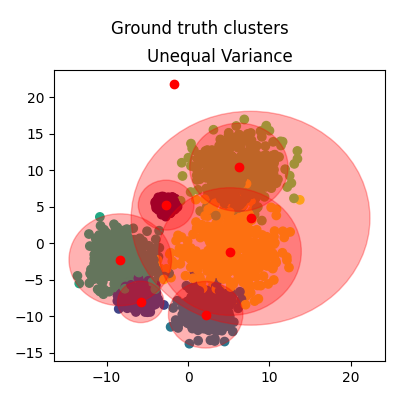

(-18.0, 18.0)

In [144]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

axs.scatter(X_varied[train_indices, 0], X_varied[train_indices, 1], c=y_varied[train_indices])
axs.set_title("Unequal Variance")

axs.scatter(alloc_protos[:,0], alloc_protos[:,1], c='red')

alloc_inds = (clvq.proto_labels<n_classes).squeeze()
alloc_protos = clvq.prototypes.cpu()[alloc_inds,:]
alloc_radii = clvq.sim_th.cpu()[alloc_inds,:]
alloc_labels = clvq.proto_labels.cpu()[alloc_inds,:].squeeze()

for i in range(len(alloc_protos)):
    if alloc_radii[i] < 8:
        circle = plt.Circle((alloc_protos[i,0], alloc_protos[i,1]), alloc_radii[i], color='r', alpha=0.3)
        axs.add_patch(circle)

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.tight_layout()
plt.show()
plt.ylim([-18,18])
plt.xlim([-18,18])

In [173]:
a = [1]
lm = 0.4
k_d = 0.01
k_m = 0.02
k_h = 0.014
sim_time = 100
u_m = [0]*100
u_h = [1]*80 + [0]*20
t = np.arange(sim_time+1)

In [174]:
for i in range(sim_time):
    a_new = a[i] - k_d*np.sin(2 * np.pi/lm * a[i]) + k_m*u_m[i] - k_h*u_h[i]
    a.append(a_new)
    

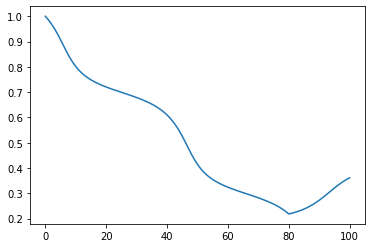

In [175]:
fig=plt.figure()
plt.plot(t, a)

# 